# Project:- Zomato Restaurant Sentimental Analysis and Clustering

Name:- Akshay Mahalle

## Github:-

# Problem Statement:
The project focuses on analyzing customer reviews to derive insights through visualizations and clustering Zomato restaurants into segments. This helps customers find the best restaurants locally and supports businesses in identifying areas for improvement. Additionally, the data provides valuable information on cuisine, pricing, and sentiment analysis, with reviewer metadata useful for identifying industry critics.

# Summary:
Performed sentiment analysis on restaurant reviews of customer perceptions and applied unsupervised machine learning to cluster restaurants based on cost and ratings. The analysis identified three distinct clusters — high-end, budget-friendly, and diverse — revealing patterns in pricing, ratings, and sentiment. This approach helped uncover insights into customer behavior and restaurant performance, supporting data-driven recommendations.

# Importing Libraries

In [244]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('vader_lexicon')

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [246]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading Data

In [248]:
metadata_df = pd.read_csv(r'C:\Users\DELL\Downloads\Zomato Restaurant names and Metadata.csv')
reviews_df = pd.read_csv(r'C:\Users\DELL\Downloads\Zomato Restaurant reviews.csv')

In [254]:
metadata_df.head()

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [252]:
metadata_df.tail()

,Name,Links,Cost,Collections,Cuisines,Timings
100,IndiBlaze,https://www.zomato.com/hyderabad/indiblaze-gac...,600,NaN,"Fast Food, Salad",11 AM to 11 PM
101,Sweet Basket,https://www.zomato.com/hyderabad/sweet-basket-...,200,NaN,"Bakery, Mithai","10 AM to 10 PM (Mon-Thu), 8 AM to 10:30 PM (Fr..."
102,Angaara Counts 3,https://www.zomato.com/hyderabad/angaara-count...,500,NaN,"North Indian, Biryani, Chinese",12 Noon to 11 PM
103,Wich Please,https://www.zomato.com/hyderabad/wich-please-1...,250,NaN,Fast Food,8am to 12:30AM (Mon-Sun)
104,Republic Of Noodles - Lemon Tree Hotel,https://www.zomato.com/hyderabad/republic-of-n...,"1,700",Pan-Asian Delicacies,"Thai, Asian, Chinese, Malaysian","11:30 AM to 3 PM, 7 PM to 12 Midnight"


In [256]:
metadata_df.shape

(105, 6)

In [258]:
metadata_df.isnull().sum()

Name            0
Links           0
Cost            0
Collections    54
Cuisines        0
Timings         1
dtype: int64

In [260]:
metadata_df["Collections"] = metadata_df.groupby("Cuisines")["Collections"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [262]:
metadata_df["Timings"].fillna(metadata_df["Timings"].mode()[0], inplace=True)

In [264]:
metadata_df.isnull().sum()

Name           0
Links          0
Cost           0
Collections    0
Cuisines       0
Timings        0
dtype: int64

In [11]:
metadata_df.duplicated().sum()

0

In [266]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  105 non-null    object
 4   Cuisines     105 non-null    object
 5   Timings      105 non-null    object
dtypes: object(6)
memory usage: 5.1+ KB


In [268]:
metadata_df['Cost'] = metadata_df['Cost'].str.replace(',', '').astype(int)

In [270]:
metadata_df.dtypes

Name           object
Links          object
Cost            int32
Collections    object
Cuisines       object
Timings        object
dtype: object

In [272]:
reviews_df.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [274]:
reviews_df.shape

(10000, 7)

# Data Wrangling

In [276]:
reviews_df.isnull().sum()

Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
Pictures       0
dtype: int64

In [278]:
reviews_df.duplicated().sum()

36

In [448]:
reviews_df.dropna(inplace = True)
reviews_df.isnull().sum()

Restaurant    0
Reviewer      0
Review        0
Rating        0
Reviews       0
Followers     0
Time          0
Pictures      0
Year          0
dtype: int64

In [282]:
reviews_df.drop_duplicates(inplace = True)
reviews_df.duplicated().sum()

0

In [284]:
reviews_df.shape

(9955, 7)

In [286]:
reviews_df[reviews_df['Rating'] == 'Like']

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
7601,The Old Madras Baking Company,Dhanasekar Kannan,One of the best pizzas to try. It served with ...,Like,"12 Reviews , 21 Followers",5/18/2019 12:31,1


In [290]:
# Convert 'Rating' to numeric, replacing errors with NaN
reviews_df['Rating'] = pd.to_numeric(reviews_df['Rating'], errors='coerce')

# Split 'Metadata' into 'Reviews' and 'Followers'
metadata_split = reviews_df['Metadata'].str.split(',', expand=True, n=1)

# Assign the first split part to 'Reviews', handling potential missing values
reviews_df['Reviews'] = pd.to_numeric(metadata_split[0].str.split(' ').str[0], errors='coerce')

# Assign the second split part to 'Followers', checking if it exists
if metadata_split.shape[1] > 1:
    reviews_df['Followers'] = pd.to_numeric(metadata_split[1].str.split(' ').str[1], errors='coerce')
else:
    reviews_df['Followers'] = None  # If no 'Followers' column exists, set to None

# Convert 'Time' to datetime, handling errors
reviews_df['Time'] = pd.to_datetime(reviews_df['Time'], errors='coerce')

# Select relevant columns
reviews_df = reviews_df[['Restaurant', 'Reviewer', 'Review', 'Rating', 'Reviews', 'Followers', 'Time', 'Pictures']]

# Check data types
print(reviews_df.dtypes)

Restaurant            object
Reviewer              object
Review                object
Rating               float64
Reviews                int64
Followers            float64
Time          datetime64[ns]
Pictures               int64
dtype: object


In [292]:
reviews_df.head()

,Restaurant,Reviewer,Review,Rating,Reviews,Followers,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,1,2.0,2019-05-25 15:54:00,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,3,2.0,2019-05-25 14:20:00,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,2,3.0,2019-05-24 22:54:00,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,1,1.0,2019-05-24 22:11:00,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,3,2.0,2019-05-24 21:37:00,0


# EDA(Exploratory Data Analysis)

In [294]:
cusines_list = metadata_df['Cuisines'].str.split(', ')
cusines_list

0      [Chinese, Continental, Kebab, European, South ...
1                       [Biryani, North Indian, Chinese]
2         [Asian, Mediterranean, North Indian, Desserts]
3      [Biryani, North Indian, Chinese, Seafood, Beve...
4      [Asian, Continental, North Indian, Chinese, Me...
                             ...                        
100                                   [Fast Food, Salad]
101                                     [Bakery, Mithai]
102                     [North Indian, Biryani, Chinese]
103                                          [Fast Food]
104                    [Thai, Asian, Chinese, Malaysian]
Name: Cuisines, Length: 105, dtype: object

The top 10 Cusines are: 
               Count of Restaurant
North Indian                   61
Chinese                        43
Continental                    21
Biryani                        16
Fast Food                      15
Asian                          15
Italian                        14
Desserts                       13
South Indian                    9
Bakery                          7


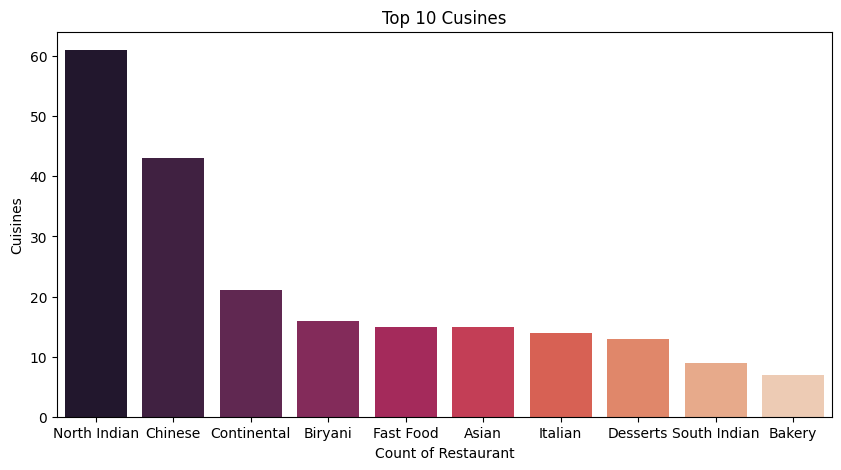

In [296]:
cusine = {}

for i in cusines_list:
  for j in i:
    if j in cusine:
      cusine[j] += 1
    else:
      cusine[j] = 1

cusine_df = pd.DataFrame(cusine.values(), index = cusine.keys(), columns = ['Count of Restaurant'])
cusine_df.sort_values(by = 'Count of Restaurant', ascending = False, inplace = True)
cusines_top_10 = cusine_df.head(10)
print('The top 10 Cusines are: \n', cusines_top_10)
cusines_top_10.reset_index()
plt.figure(figsize = (10, 5))
sns.barplot(x = cusines_top_10.index, y = 'Count of Restaurant', data = cusines_top_10, palette = 'rocket')
plt.xlabel('Count of Restaurant')
plt.ylabel('Cuisines')
plt.title('Top 10 Cusines')
plt.show()

**Insights:** North Indian cuisine stands out as the most popular, followed by Chinese, reflecting strong cultural preferences and high demand. Continental, Biryani, and Fast Food hold moderate popularity, while niche cuisines like South Indian, Desserts, and Bakery offer opportunities for unique market positioning. This insight suggests that restaurants focusing on widely loved cuisines may attract more customers, while niche cuisines could appeal to specialized tastes with less competition.

In [298]:
restaurant_cost = metadata_df.groupby('Name')['Cost'].mean().reset_index(name = 'Cost')
avg_cost = np.average(restaurant_cost['Cost'])
print('The average cost of a restaurant is: ', avg_cost)

The average cost of a restaurant is:  861.4285714285714


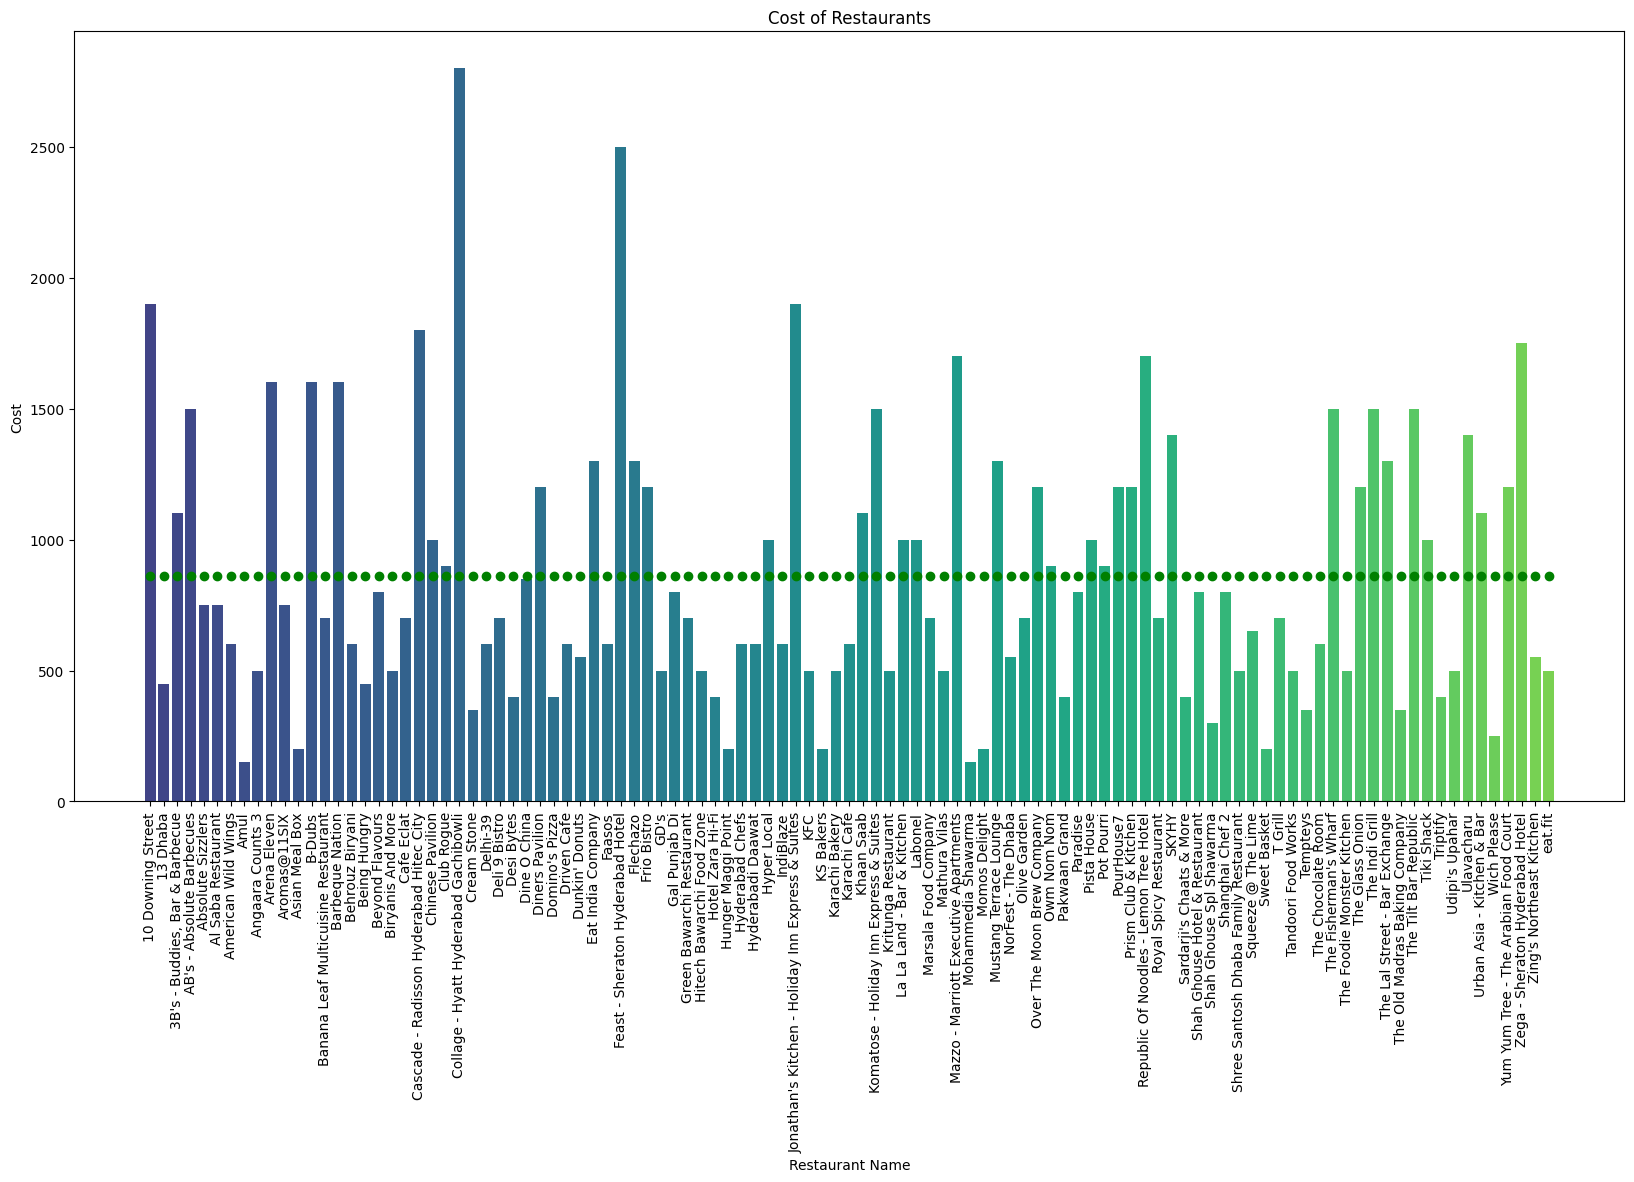

In [300]:
plt.figure(figsize = (20, 10))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(restaurant_cost)))
plt.bar(restaurant_cost['Name'], restaurant_cost['Cost'], color = colors)

for i in restaurant_cost['Name']:
  plt.scatter(i, avg_cost, color = 'g')

plt.xlabel('Restaurant Name')
plt.ylabel('Cost')
plt.xticks(rotation = 90)
plt.title('Cost of Restaurants')
plt.show()

**Insights:** The cost analysis of restaurants reveals significant variation, with a mix of budget-friendly and high-end options. The green dotted line representing the average cost highlights that many restaurants fall below this mark, making affordable dining more accessible. However, the presence of premium restaurants charging well above the average indicates a market catering to diverse spending capacities, from casual diners to luxury seekers.

In [302]:
restaurant_cost.sort_values(by = 'Cost', ascending = False, inplace = True)
print('The Top 5 Costliest Restaurant in Hyderabad is: \n', restaurant_cost.nlargest(5, 'Cost'))

The Top 5 Costliest Restaurant in Hyderabad is: 
                                                  Name    Cost
23               Collage - Hyatt Hyderabad Gachibowli  2800.0
35                   Feast - Sheraton Hyderabad Hotel  2500.0
0                                   10 Downing Street  1900.0
48  Jonathan's Kitchen - Holiday Inn Express & Suites  1900.0
20            Cascade - Radisson Hyderabad Hitec City  1800.0


In [304]:
print('The Top 5 Cheapest Restaurant in Hyderabad is: \n', restaurant_cost[-5:])

The Top 5 Cheapest Restaurant in Hyderabad is: 
                    Name   Cost
62        Momos Delight  200.0
43   Hunger Maggi Point  200.0
50            KS Bakers  200.0
7                  Amul  150.0
61  Mohammedia Shawarma  150.0


In [306]:
restaurant_rating = reviews_df.groupby('Restaurant')['Rating'].mean().reset_index(name = 'Average Rating')
avg_rating = np.average(restaurant_rating['Average Rating'])
print('The average rating of a restaurant is: ', avg_rating)

The average rating of a restaurant is:  3.6018905398523047


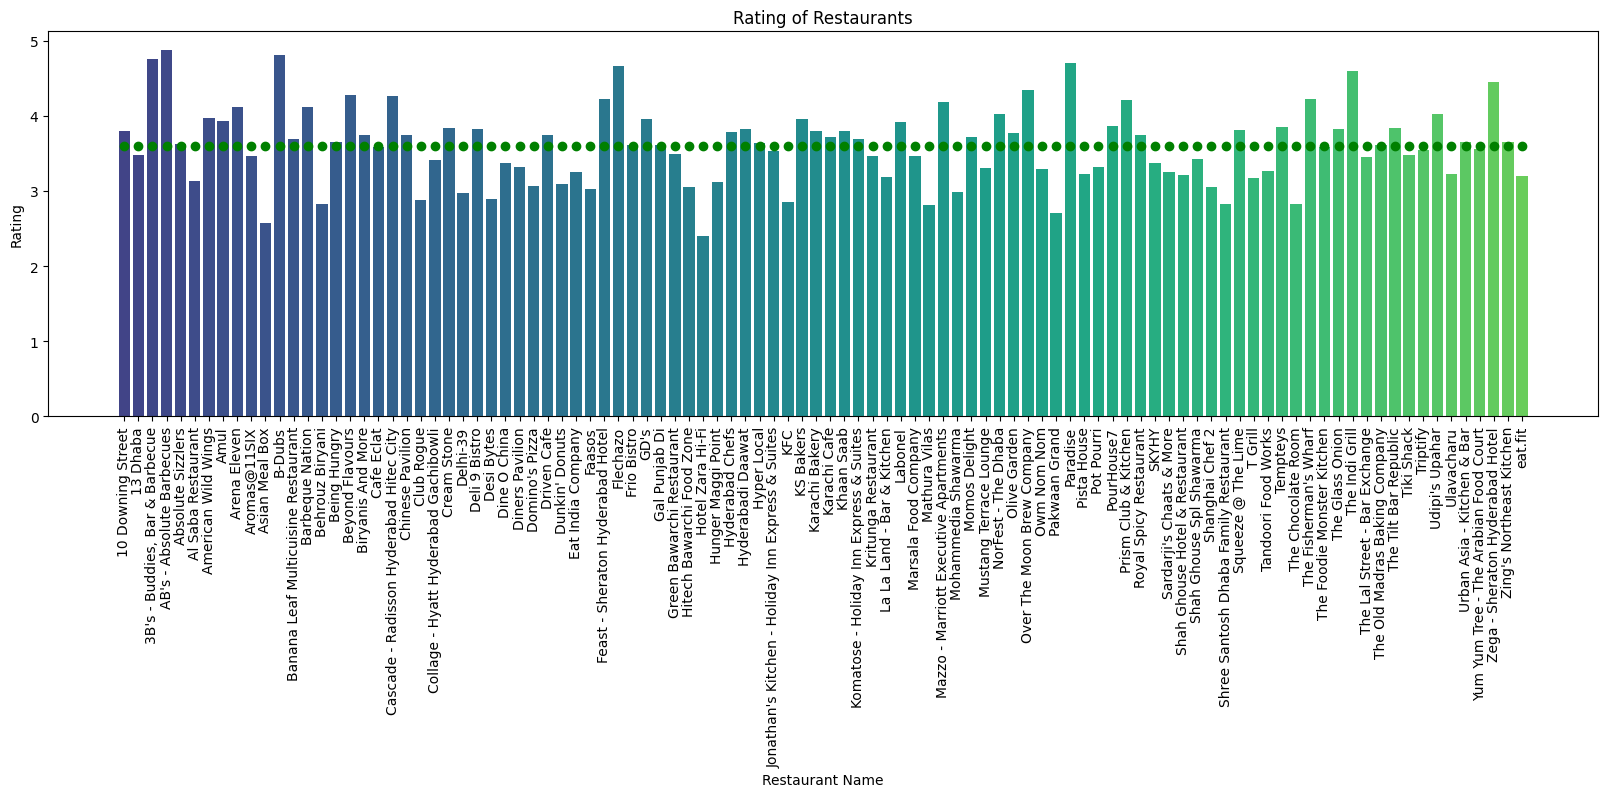

In [308]:
plt.figure(figsize = (20,5))
plt.bar(restaurant_rating['Restaurant'], restaurant_rating['Average Rating'], color = colors)

for i in restaurant_rating['Restaurant']:
  plt.scatter(i, avg_rating, color = 'g')

plt.xlabel('Restaurant Name')
plt.ylabel('Rating')
plt.xticks(rotation = 90)
plt.title('Rating of Restaurants')
plt.show()

**Insights:** The restaurant ratings analysis shows a majority maintaining above-average ratings, suggesting overall positive customer satisfaction. A few standout restaurants surpass the 4.5 mark, indicating exceptional service or food quality. Meanwhile, lower-rated spots falling below the average line hint at potential areas for improvement, such as food, service, or ambiance.

In [310]:
restaurant_rating.sort_values(by = 'Average Rating', ascending = False, inplace = True)
print('The Top 5 Highest Rated Restaurant in Hyderabad is: \n', restaurant_rating.nlargest(5, 'Average Rating'))

The Top 5 Highest Rated Restaurant in Hyderabad is: 
                         Restaurant  Average Rating
3        AB's - Absolute Barbecues            4.88
11                          B-Dubs            4.81
2   3B's - Buddies, Bar & Barbecue            4.76
67                        Paradise            4.70
35                        Flechazo            4.66


In [312]:
print('The Top 5 Lowest Rated Restaurant in Hyderabad is: \n', restaurant_rating[-5:])

The Top 5 Lowest Rated Restaurant in Hyderabad is: 
           Restaurant  Average Rating
14   Behrouz Biryani           2.825
57     Mathura Vilas           2.820
66     Pakwaan Grand           2.710
10    Asian Meal Box           2.580
41  Hotel Zara Hi-Fi           2.400


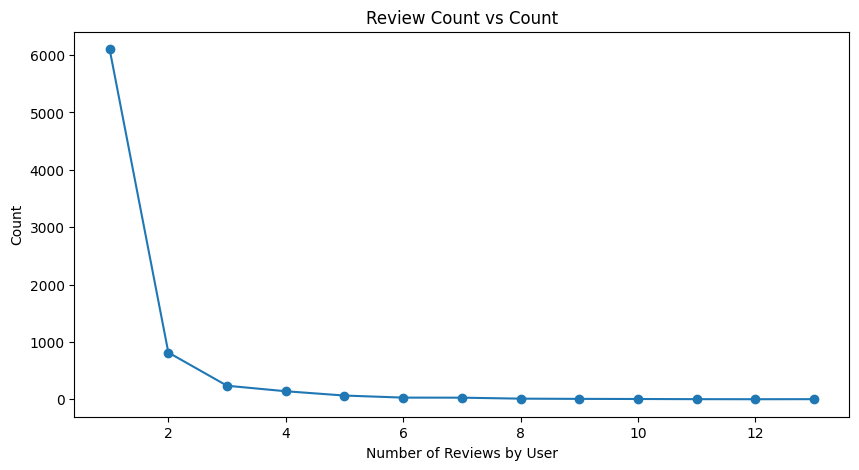

In [314]:
top_reviewers = reviews_df.groupby('Reviewer')['Review'].count().reset_index(name = 'Review Count')
top_reviewers_count = top_reviewers.groupby('Review Count').count().reset_index()

plt.figure(figsize = (10,5))
plt.plot(top_reviewers_count['Review Count'], top_reviewers_count['Reviewer'])
plt.scatter(top_reviewers_count['Review Count'], top_reviewers_count['Reviewer'])
plt.xlabel('Number of Reviews by User')
plt.ylabel('Count')
plt.title('Review Count vs Count')
plt.show()

**Insights:** The analysis of user reviews shows that most users leave only one review, with a sharp decline in users contributing multiple reviews. This suggests that while many customers share feedback, only a small portion of highly engaged users leave repeated reviews. Encouraging more frequent reviewers could provide a richer, more balanced understanding of restaurant performance.

In [316]:
top_reviewers.sort_values(by = 'Review Count', ascending = False, inplace = True)
print('Total of {} Users have Submitted'.format(len(top_reviewers)))
print('---------------The Top 5 Reviewers are: ----------------\n', top_reviewers[:10])

Total of 7442 Users have Submitted
---------------The Top 5 Reviewers are: ----------------
                             Reviewer  Review Count
654                           Ankita            13
3855                     Parijat Ray            13
2652                           Kiran            12
7009                    Vedant Killa            11
2311                       Jay Mehta            11
3131           Manojkumar D Nambisan            10
6126                         Sravani            10
5954                      Siva Kumar            10
4256                        Priyanka            10
264   Age Of Foodies (Suraj Karambe)            10


In [318]:
top_reviewers_rating = reviews_df.groupby('Reviewer')['Rating'].mean().reset_index(name = 'Average Rating')
avg_review_rating = np.average(top_reviewers_rating['Average Rating'])
review_ratings = pd.merge(top_reviewers, top_reviewers_rating, left_on = 'Reviewer', right_on = 'Reviewer', how = 'inner')
top_reviews = review_ratings[:10]
print('The average rating of a reviewer is: ', avg_review_rating)
print(top_reviews)

The average rating of a reviewer is:  3.578301536992077
                         Reviewer  Review Count  Average Rating
0                          Ankita            13        3.923077
1                     Parijat Ray            13        3.192308
2                           Kiran            12        4.500000
3                    Vedant Killa            11        4.000000
4                       Jay Mehta            11        3.727273
5           Manojkumar D Nambisan            10        3.700000
6                         Sravani            10        4.000000
7                      Siva Kumar            10        3.600000
8                        Priyanka            10        2.600000
9  Age Of Foodies (Suraj Karambe)            10        3.500000


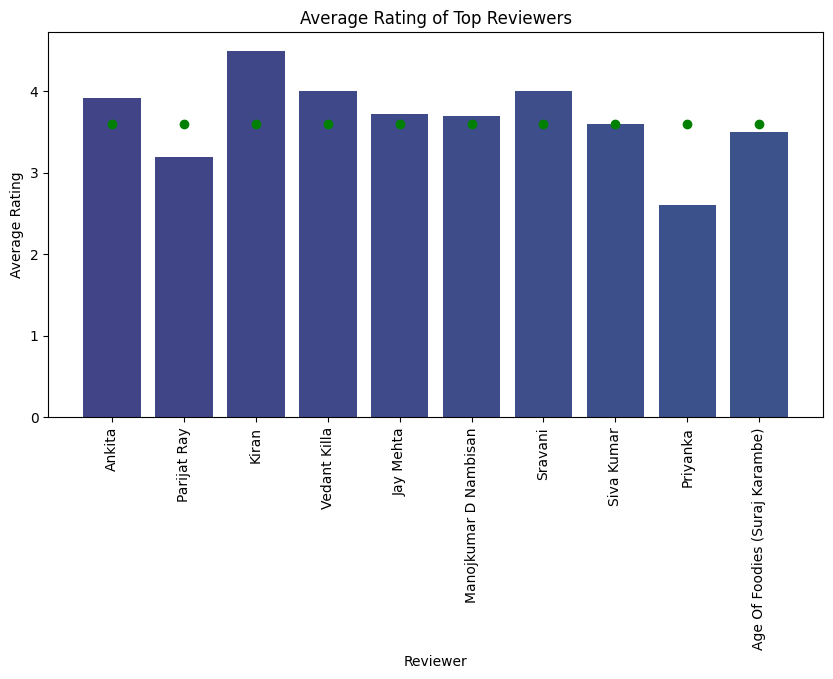

In [320]:
plt.figure(figsize = (10,5))
plt.bar(top_reviews['Reviewer'], top_reviews['Average Rating'], color = colors)

for i in top_reviews['Reviewer']:
  plt.scatter(i, avg_rating, color = 'g')

plt.xlabel('Reviewer')
plt.ylabel('Average Rating')
plt.xticks(rotation = 90)
plt.title('Average Rating of Top Reviewers')
plt.show()

**Insights:** This visualization highlights the average ratings given by top reviewers. It looks like some reviewers (like Kiran) tend to give more positive ratings on average, while others (e.g., Priyanka) lean toward lower ratings. This could indicate different reviewing styles — some might be more critical, while others are more generous. Analyzing these patterns can help identify reliable, balanced reviewers or spot potential biases in the data.

In [322]:
top_reviews = pd.merge(top_reviewers, reviews_df, left_on = 'Reviewer', right_on = 'Reviewer', how = 'inner')
top_reviews.head()

,Reviewer,Review Count,Restaurant,Review,Rating,Reviews,Followers,Time,Pictures
0,Ankita,13,Hyper Local,We liked the chhole bhature as it was not at a...,4.0,10,8.0,2019-04-07 17:29:00,0
1,Ankita,13,Absolute Sizzlers,A Friday outing in Absolute Sizzlers. Quite po...,4.0,76,211.0,2019-03-13 13:22:00,5
2,Ankita,13,The Lal Street - Bar Exchange,A good place to hangout. They have indoor as w...,4.0,10,8.0,2019-04-07 17:31:00,0
3,Ankita,13,Jonathan's Kitchen - Holiday Inn Express & Suites,A quick dinner for last Sunday of 2018 landed ...,4.0,76,211.0,2019-01-02 17:20:00,1
4,Ankita,13,SKYHY,"So beautiful, great DJ nights, economic, great...",5.0,10,179.0,2018-10-02 14:10:00,0


In [43]:
top_review_avg = top_reviews.groupby(['Reviewer', 'Restaurant'])['Rating'].mean().reset_index(name = 'Average Rating')
top_review_avg.head()

,Reviewer,Restaurant,Average Rating
0,#FOODPORN,Zega - Sheraton Hyderabad Hotel,5.0
1,#chloesviews // CAH,eat.fit,5.0
2,$ign,SKYHY,4.0
3,4mybanti,Ulavacharu,2.0
4,@FuloriBinaChutneyKaiseBani,Chinese Pavilion,5.0


In [324]:
top_n_reviewers = top_reviews['Reviewer'].value_counts().nlargest(10).index
top_n_reviewers
top_review_avg = top_review_avg[top_review_avg['Reviewer'].isin(top_n_reviewers)]

In [326]:
rating_pivot = pd.pivot_table(top_review_avg, index = 'Restaurant', columns = 'Reviewer', values = 'Average Rating')
rating_pivot.head()

Reviewer,Age Of Foodies (Suraj Karambe),Ankita,Jay Mehta,Kiran,Manojkumar D Nambisan,Parijat Ray,Priyanka,Siva Kumar,Sravani,Vedant Killa
Restaurant,,,,,,,,,,
10 Downing Street,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,3.0
13 Dhaba,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Absolute Sizzlers,NaN,4.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
American Wild Wings,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amul,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [328]:
rating_pivot.replace(np.NaN, 0)

Reviewer,Age Of Foodies (Suraj Karambe),Ankita,Jay Mehta,Kiran,Manojkumar D Nambisan,Parijat Ray,Priyanka,Siva Kumar,Sravani,Vedant Killa
Restaurant,,,,,,,,,,
10 Downing Street,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,3.0
13 Dhaba,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Absolute Sizzlers,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
American Wild Wings,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amul,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
Udipi's Upahar,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ulavacharu,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
Yum Yum Tree - The Arabian Food Court,3.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0


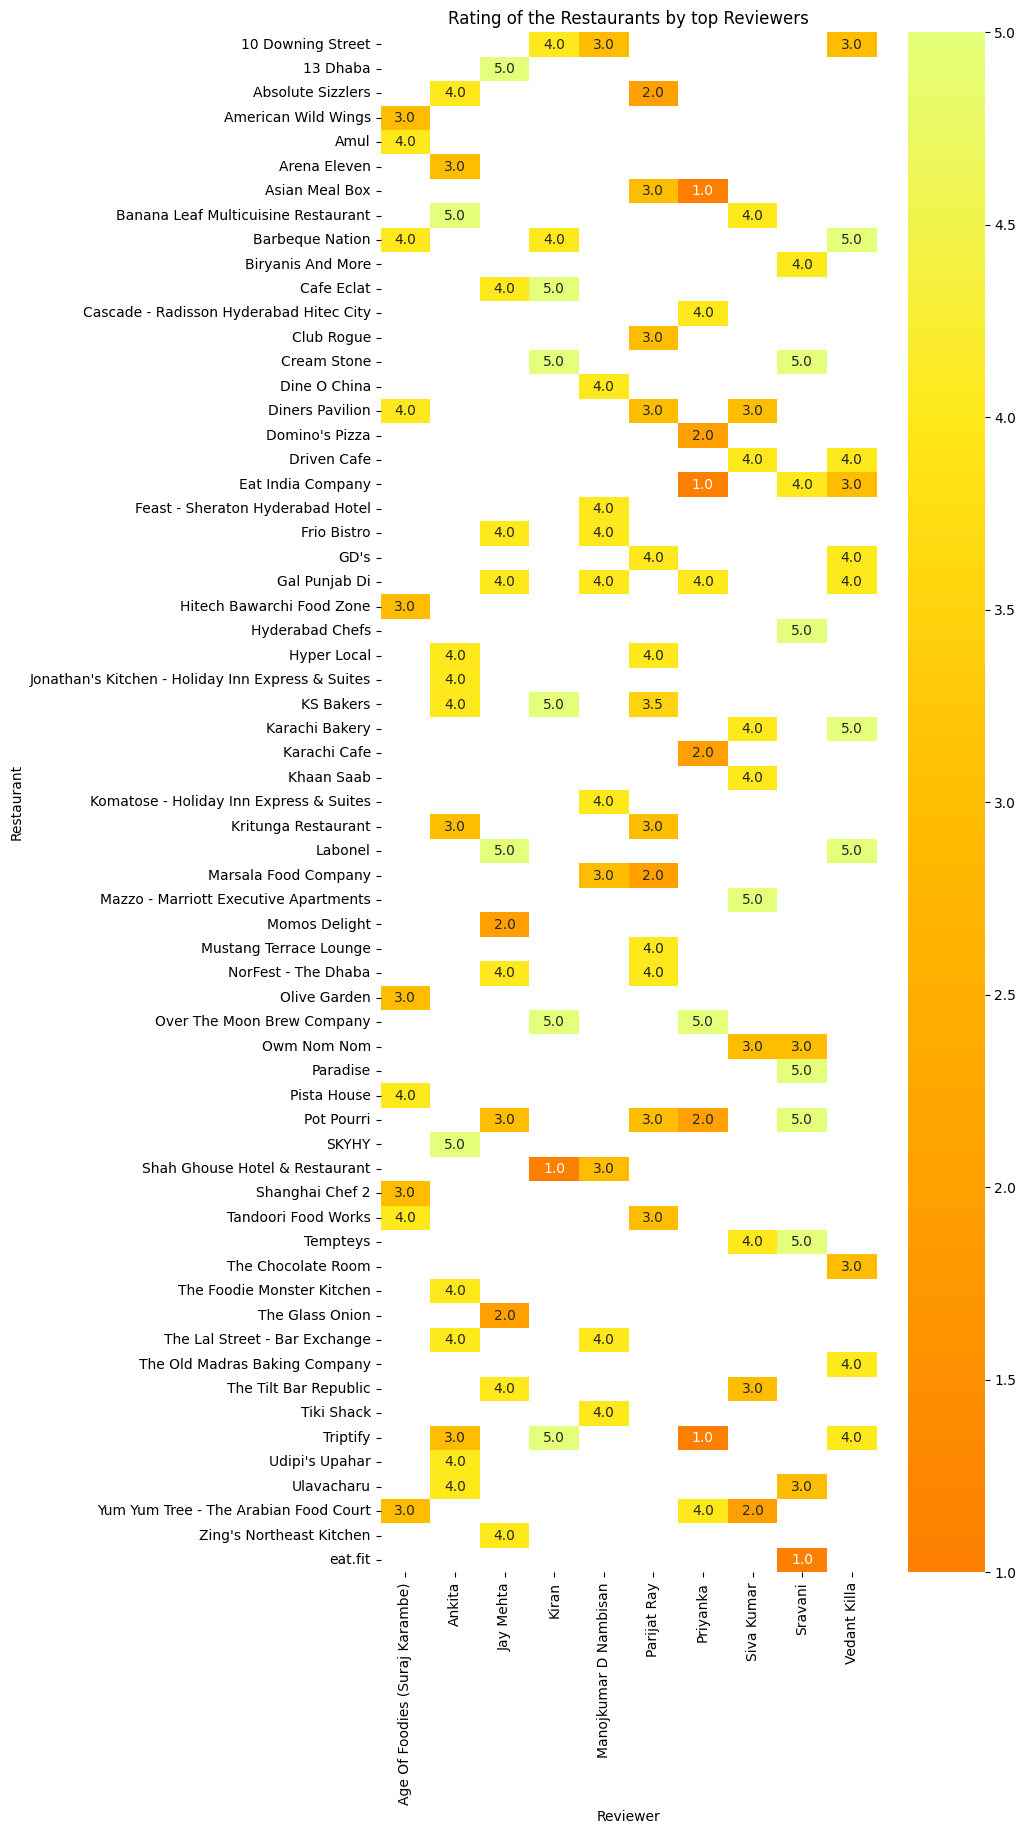

In [330]:
plt.figure(figsize = (8,20))
sns.heatmap(rating_pivot, annot = True, fmt = '.1f', cmap = 'Wistia_r')
plt.title('Rating of the Restaurants by top Reviewers')
plt.xlabel('Reviewer')
plt.ylabel('Restaurant')
plt.show()

**Insights:** This heatmap gives a great overview of how different top reviewers rate various restaurants. It’s easy to spot patterns — like certain reviewers consistently giving lower or higher ratings — and identify restaurants with more balanced feedback across multiple reviewers.

Some interesting Points we can see in the Heatmap:

- Restaurants with mostly green (4.0 or 5.0) blocks across reviewers are likely crowd favorites.
- The orange/red blocks (1.0 or 2.0) show clear outliers — either the restaurant had a bad day or that reviewer is particularly tough to impress.
- A mix of high and low ratings for the same restaurant hints at inconsistency in service or food quality.

**Insights:** Looks like the word cloud highlights some key trends! "Hyderabad," "Restaurant," "Cafe," "Hotel," "Shawarma," "Dhaba," and "Biryani" stand out prominently — which makes sense given the food culture in Hyderabad.

It seems like casual and street food spots ("Shawarma," "Dhaba," "Barbecue") are just as popular as more upscale places ("Hotel," "Suites," "Pavilion").

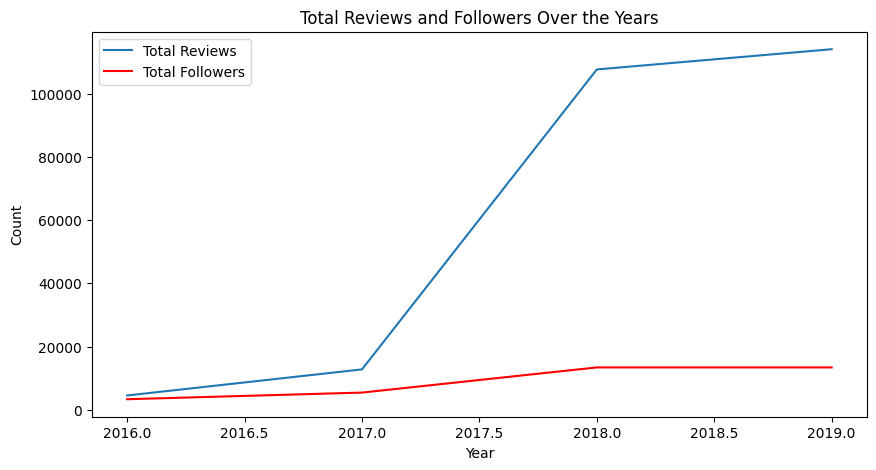

In [332]:
reviews_df['Year'] = pd.DatetimeIndex(reviews_df['Time']).year
reviews = reviews_df.groupby('Year')['Reviews'].sum().reset_index(name = 'Total Reviews')
followers = reviews_df.groupby('Year')['Followers'].max().reset_index(name = 'Total Followers')
review_follow = pd.merge(reviews, followers, left_on = 'Year', right_on = 'Year', how = 'inner')

plt.figure(figsize = (10,5))
plt.plot(review_follow['Year'], review_follow['Total Reviews'], label = 'Total Reviews')
plt.plot(review_follow['Year'], review_follow['Total Followers'], label = 'Total Followers', color = 'r')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Total Reviews and Followers Over the Years')
plt.legend()
plt.show()

**Insights:** This trend of reviews skyrocketed between 2017 and 2018, while follower growth seems to plateau after 2018.

It looks like engagement (reviews) rose dramatically, but the community (followers) stopped expanding as quickly

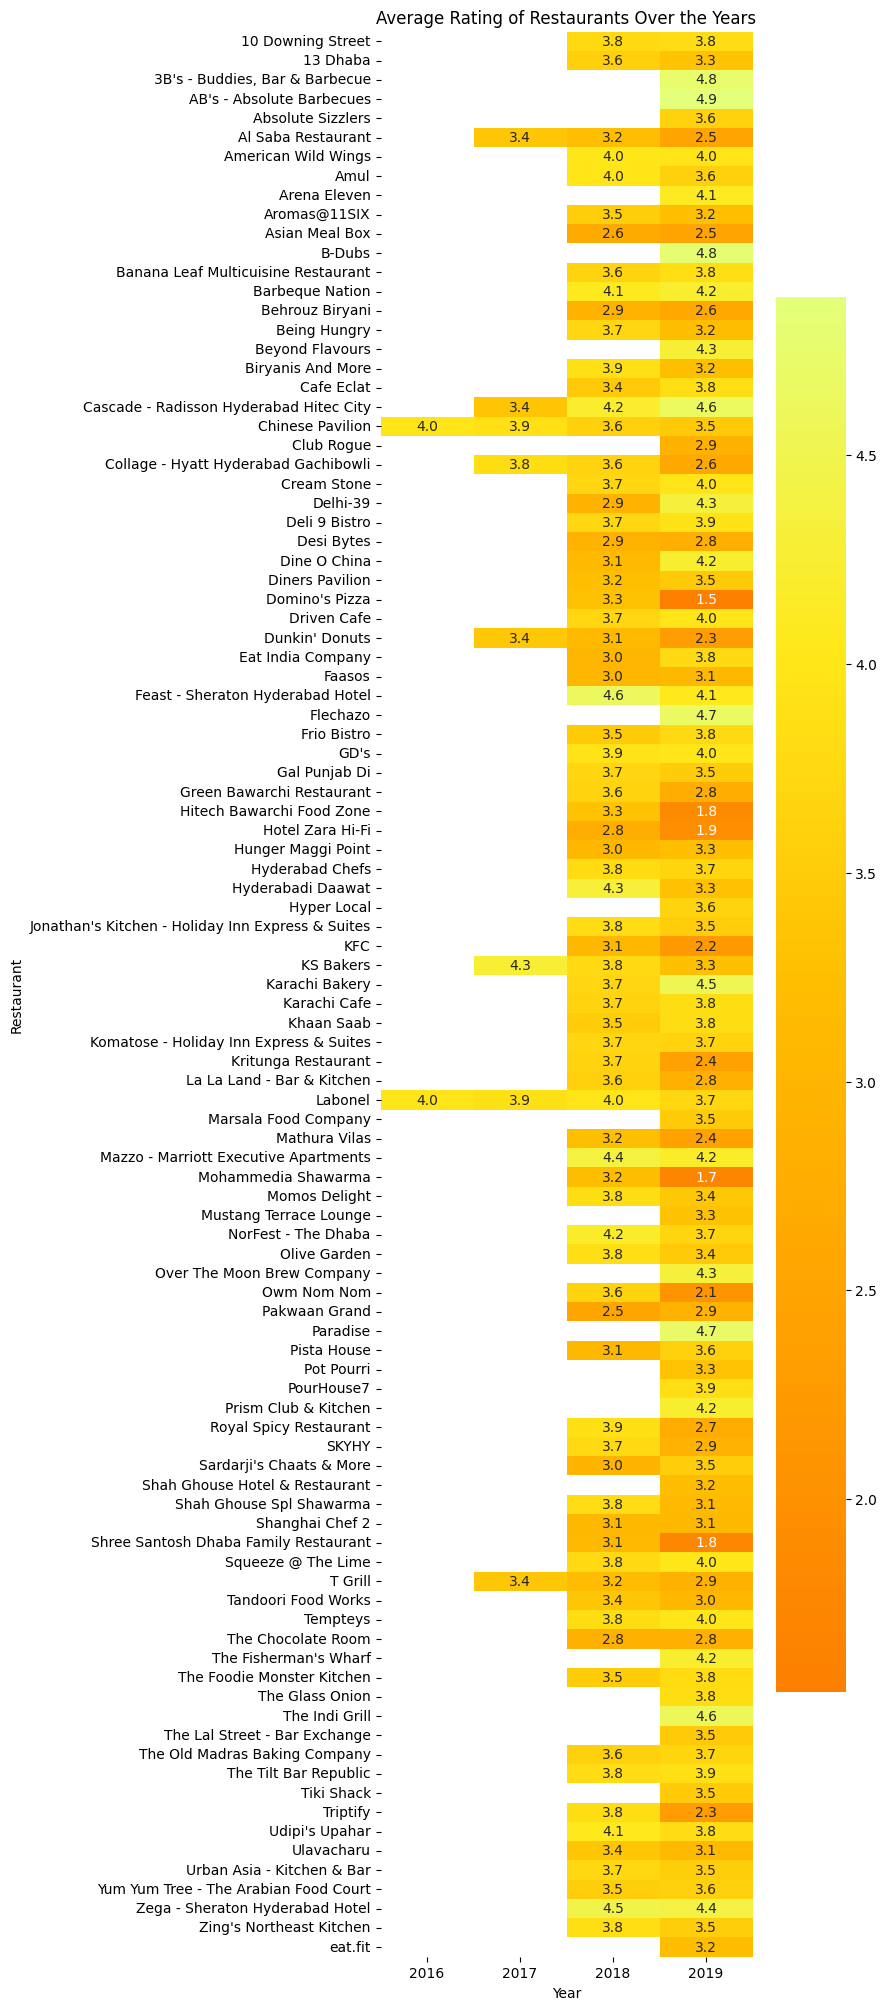

In [334]:
rest = reviews_df.groupby(['Restaurant', 'Year'])['Rating'].mean().reset_index(name = 'Average Score')
pivot_df = pd.pivot(rest, index = 'Restaurant', columns = 'Year', values = 'Average Score')
plt.figure(figsize = (6, 25))
sns.heatmap(pivot_df, annot = True, fmt = '.1f', cmap = 'Wistia_r')
plt.title('Average Rating of Restaurants Over the Years')
plt.xlabel('Year')
plt.ylabel('Restaurant')
plt.show()

**Insights:** The heatmap shows some restaurants maintained high ratings consistently, while others saw noticeable declines over time.
- AB's - Absolute Barbecues stayed strong with ratings around 4.9.
- Driven Cafe significantly increased in 2019.
- Behrouz Biryani struggled, dipping from 2.9 to 2.6.

# Sentimental Analysis

In [336]:
reviews_df['Review']

0       The ambience was good, food was quite good . h...
1       Ambience is too good for a pleasant evening. S...
2       A must try.. great food great ambience. Thnx f...
3       Soumen das and Arun was a great guy. Only beca...
4       Food is good.we ordered Kodi drumsticks and ba...
                              ...                        
9995    Madhumathi Mahajan Well to start with nice cou...
9996    This place has never disappointed us.. The foo...
9997    Bad rating is mainly because of "Chicken Bone ...
9998    I personally love and prefer Chinese Food. Had...
9999    Checked in here to try some delicious chinese ...
Name: Review, Length: 9955, dtype: object

In [338]:
def word_req(text):
  st = ''
  punctuations = [',', '@', '!', '(',')', '-', '/', '#', '%', '&', '"', "'"]
  stops = ['\n', '.']
  st1 = text.lower()

  for i in st1:
    for j in i:
      if j in punctuations:
        continue
      elif j in stops:
        st = st + ' '
      else:
        st = st + j

  return st

In [340]:
review_list = reviews_df.groupby('Review').apply(lambda x: word_req(x['Review'].str).split()).reset_index(name = 'Word List')
merged = pd.merge(reviews_df, review_list, left_on = 'Review', right_on = 'Review', how = 'inner')
merged

,Restaurant,Reviewer,Review,Rating,Reviews,Followers,Time,Pictures,Year,Word List
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,1,2.0,2019-05-25 15:54:00,0,2019,"[the, ambience, was, good, food, was, quite, g..."
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,3,2.0,2019-05-25 14:20:00,0,2019,"[ambience, is, too, good, for, a, pleasant, ev..."
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,2,3.0,2019-05-24 22:54:00,0,2019,"[a, must, try, great, food, great, ambience, t..."
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,1,1.0,2019-05-24 22:11:00,0,2019,"[soumen, das, and, arun, was, a, great, guy, o..."
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,3,2.0,2019-05-24 21:37:00,0,2019,"[food, is, good, we, ordered, kodi, drumsticks..."
...,...,...,...,...,...,...,...,...,...,...
9950,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3.0,53,54.0,2016-06-05 00:08:00,0,2016,"[madhumathi, mahajan, well, to, start, with, n..."
9951,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,2,53.0,2016-06-04 22:01:00,0,2016,"[this, place, has, never, disappointed, us, th..."
9952,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,65,423.0,2016-06-03 10:37:00,3,2016,"[bad, rating, is, mainly, because, of, chicken..."
9953,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4.0,13,144.0,2016-05-31 17:22:00,0,2016,"[i, personally, love, and, prefer, chinese, fo..."


In [342]:
sia = SentimentIntensityAnalyzer()
merged['Cleaned Text'] = merged['Word List'].apply(lambda words: ' '.join(words))

In [344]:
merged

,Restaurant,Reviewer,Review,Rating,Reviews,Followers,Time,Pictures,Year,Word List,Cleaned Text
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,1,2.0,2019-05-25 15:54:00,0,2019,"[the, ambience, was, good, food, was, quite, g...",the ambience was good food was quite good had ...
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,3,2.0,2019-05-25 14:20:00,0,2019,"[ambience, is, too, good, for, a, pleasant, ev...",ambience is too good for a pleasant evening se...
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,2,3.0,2019-05-24 22:54:00,0,2019,"[a, must, try, great, food, great, ambience, t...",a must try great food great ambience thnx for ...
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,1,1.0,2019-05-24 22:11:00,0,2019,"[soumen, das, and, arun, was, a, great, guy, o...",soumen das and arun was a great guy only becau...
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,3,2.0,2019-05-24 21:37:00,0,2019,"[food, is, good, we, ordered, kodi, drumsticks...",food is good we ordered kodi drumsticks and ba...
...,...,...,...,...,...,...,...,...,...,...,...
9950,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3.0,53,54.0,2016-06-05 00:08:00,0,2016,"[madhumathi, mahajan, well, to, start, with, n...",madhumathi mahajan well to start with nice cou...
9951,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,2,53.0,2016-06-04 22:01:00,0,2016,"[this, place, has, never, disappointed, us, th...",this place has never disappointed us the food ...
9952,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,65,423.0,2016-06-03 10:37:00,3,2016,"[bad, rating, is, mainly, because, of, chicken...",bad rating is mainly because of chicken bone f...
9953,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4.0,13,144.0,2016-05-31 17:22:00,0,2016,"[i, personally, love, and, prefer, chinese, fo...",i personally love and prefer chinese food had ...


In [350]:
tqdm.pandas()  # Enables progress bar for Pandas operations
merged['Sentiment_Score'] = merged['Cleaned Text'].progress_apply(lambda text: sia.polarity_scores(text)['compound'])

100%|██████████| 9955/9955 [00:09<00:00, 1059.10it/s]


In [352]:
merged

,Restaurant,Reviewer,Review,Rating,Reviews,Followers,Time,Pictures,Year,Word List,Cleaned Text,Sentiment_Score
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,1,2.0,2019-05-25 15:54:00,0,2019,"[the, ambience, was, good, food, was, quite, g...",the ambience was good food was quite good had ...,0.9664
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,3,2.0,2019-05-25 14:20:00,0,2019,"[ambience, is, too, good, for, a, pleasant, ev...",ambience is too good for a pleasant evening se...,0.9360
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,2,3.0,2019-05-24 22:54:00,0,2019,"[a, must, try, great, food, great, ambience, t...",a must try great food great ambience thnx for ...,0.9186
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,1,1.0,2019-05-24 22:11:00,0,2019,"[soumen, das, and, arun, was, a, great, guy, o...",soumen das and arun was a great guy only becau...,0.8591
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,3,2.0,2019-05-24 21:37:00,0,2019,"[food, is, good, we, ordered, kodi, drumsticks...",food is good we ordered kodi drumsticks and ba...,0.9432
...,...,...,...,...,...,...,...,...,...,...,...,...
9950,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3.0,53,54.0,2016-06-05 00:08:00,0,2016,"[madhumathi, mahajan, well, to, start, with, n...",madhumathi mahajan well to start with nice cou...,0.9923
9951,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,2,53.0,2016-06-04 22:01:00,0,2016,"[this, place, has, never, disappointed, us, th...",this place has never disappointed us the food ...,0.9710
9952,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,65,423.0,2016-06-03 10:37:00,3,2016,"[bad, rating, is, mainly, because, of, chicken...",bad rating is mainly because of chicken bone f...,0.9836
9953,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4.0,13,144.0,2016-05-31 17:22:00,0,2016,"[i, personally, love, and, prefer, chinese, fo...",i personally love and prefer chinese food had ...,0.9481


In [354]:
def classify_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [356]:
merged['Sentiment_Label'] = merged['Sentiment_Score'].apply(classify_sentiment)

In [358]:
merged

,Restaurant,Reviewer,Review,Rating,Reviews,Followers,Time,Pictures,Year,Word List,Cleaned Text,Sentiment_Score,Sentiment_Label
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,1,2.0,2019-05-25 15:54:00,0,2019,"[the, ambience, was, good, food, was, quite, g...",the ambience was good food was quite good had ...,0.9664,Positive
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,3,2.0,2019-05-25 14:20:00,0,2019,"[ambience, is, too, good, for, a, pleasant, ev...",ambience is too good for a pleasant evening se...,0.9360,Positive
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,2,3.0,2019-05-24 22:54:00,0,2019,"[a, must, try, great, food, great, ambience, t...",a must try great food great ambience thnx for ...,0.9186,Positive
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,1,1.0,2019-05-24 22:11:00,0,2019,"[soumen, das, and, arun, was, a, great, guy, o...",soumen das and arun was a great guy only becau...,0.8591,Positive
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,3,2.0,2019-05-24 21:37:00,0,2019,"[food, is, good, we, ordered, kodi, drumsticks...",food is good we ordered kodi drumsticks and ba...,0.9432,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9950,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3.0,53,54.0,2016-06-05 00:08:00,0,2016,"[madhumathi, mahajan, well, to, start, with, n...",madhumathi mahajan well to start with nice cou...,0.9923,Positive
9951,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,2,53.0,2016-06-04 22:01:00,0,2016,"[this, place, has, never, disappointed, us, th...",this place has never disappointed us the food ...,0.9710,Positive
9952,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,65,423.0,2016-06-03 10:37:00,3,2016,"[bad, rating, is, mainly, because, of, chicken...",bad rating is mainly because of chicken bone f...,0.9836,Positive
9953,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4.0,13,144.0,2016-05-31 17:22:00,0,2016,"[i, personally, love, and, prefer, chinese, fo...",i personally love and prefer chinese food had ...,0.9481,Positive


In [360]:
print(merged['Sentiment_Label'].value_counts())

Sentiment_Label
Positive    7002
Negative    1843
Neutral     1110
Name: count, dtype: int64


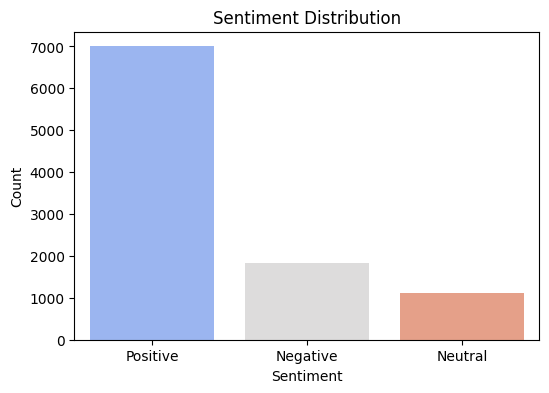

In [362]:
plt.figure(figsize=(6,4))
sns.countplot(x=merged['Sentiment_Label'], palette='coolwarm')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

**Insights:**
- Positive: Dominates the chart.
- Negative: A smaller but noticeable chunk.
- Neutral: The smallest category.

In [364]:
def most_common_words(texts, n = 20):
  all_words = ' '.join(texts).split()
  return Counter(all_words).most_common(n)

In [366]:
positive_reviews = merged[merged['Sentiment_Label'] == 'Positive']['Cleaned Text']
negative_reviews = merged[merged['Sentiment_Label'] == 'Negative']['Cleaned Text']
neutral_reviews = merged[merged['Sentiment_Label'] == 'Neutral']['Cleaned Text']

In [368]:
top_positive_words = most_common_words(positive_reviews)
top_negative_words = most_common_words(negative_reviews)
top_neutral_words = most_common_words(neutral_reviews)

In [370]:
print('The Top Positive Words are: \n:', top_positive_words)
print('The Top Negative Words are: \n:', top_negative_words)
print('The Top Neutral Words are: \n:', top_neutral_words)

The Top Positive Words are: 
: [('the', 19164), ('and', 14880), ('a', 8350), ('was', 8192), ('to', 7881), ('is', 7736), ('good', 6324), ('of', 6121), ('i', 5587), ('for', 5427), ('food', 5203), ('place', 5035), ('with', 4807), ('it', 4692), ('in', 4269), ('this', 3790), ('we', 3205), ('very', 2917), ('but', 2615), ('have', 2557)]
The Top Negative Words are: 
: [('the', 3760), ('and', 2523), ('was', 1927), ('to', 1854), ('i', 1842), ('not', 1452), ('is', 1377), ('a', 1261), ('of', 1217), ('food', 1107), ('it', 1104), ('for', 1030), ('this', 959), ('in', 872), ('they', 869), ('we', 748), ('very', 736), ('but', 721), ('with', 627), ('place', 614)]
The Top Neutral Words are: 
: [('the', 312), ('goodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgood

In [372]:
import re

def repitive_word(text):
  return re.sub(r'\b(\w+?)\1+\b', r'\1', text)

merged['Cleaned Text'] = merged['Cleaned Text'].apply(repitive_word)

top_neutral_words = most_common_words(merged[merged['Sentiment_Label'] == 'Neutral']['Cleaned Text'])
print('The Top Neutral Words are \n:', top_neutral_words)

The Top Neutral Words are 
: [('the', 312), ('good', 311), ('and', 214), ('was', 205), ('to', 141), ('is', 140), ('not', 138), ('i', 133), ('time', 126), ('a', 117), ('of', 117), ('food', 115), ('on', 106), ('for', 100), ('it', 98), ('in', 93), ('ordered', 83), ('very', 82), ('delivery', 79), ('we', 71)]


In [374]:
def word_cloud(words, text):
  wordcloud = WordCloud(width = 1500, height = 1500,
                         background_color = 'black',
                         min_font_size = 10).generate_from_frequencies(dict(words))

  plt.figure(figsize = (8, 5))
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.title(text)
  plt.tight_layout()
  plt.show()

In [70]:
# Find negative reviews containing "food"
negative_food_reviews = merged[(merged['Sentiment_Label'] == 'Negative') & (merged['Cleaned Text'].str.contains('food'))]

print(negative_food_reviews[['Restaurant', 'Review', 'Sentiment_Score', 'Cleaned Text']].head(10))

         Restaurant                                             Review  \
29  Beyond Flavours  Food is descent enough. Desert options were al...   
66  Beyond Flavours  we went for a team lunch, such a worst restaur...   
75  Beyond Flavours  I have been at this place for dinner a few day...   
80  Beyond Flavours  Hostile staff, okeish food, not so great ambia...   
83  Beyond Flavours  Food quality and taste is not good. Super slow...   
89  Beyond Flavours  Had a very bad experience here\nbeyond flavour...   
91  Beyond Flavours  I liked the food and ambience but the problem ...   
92  Beyond Flavours  It’s a worst service experience. Food was OK. ...   
95  Beyond Flavours  Was there for office lunch outing. Rating woul...   
98  Beyond Flavours  Pathetic and horrible experience\nAmbience and...   

    Sentiment_Score                                       Cleaned Text  
29          -0.1531  food is descent enough desert options were als...  
66          -0.4310  we went for a team

## Unsupervised Machine Learning Analysis

In [376]:
merged_df = pd.merge(merged, metadata_df, left_on = 'Restaurant', right_on = 'Name', how = 'inner')
merged_df.head()

,Restaurant,Reviewer,Review,Rating,Reviews,Followers,Time,Pictures,Year,Word List,Cleaned Text,Sentiment_Score,Sentiment_Label,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,1,2.0,2019-05-25 15:54:00,0,2019,"[the, ambience, was, good, food, was, quite, g...",the ambience was good food was quite good had ...,0.9664,Positive,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,3,2.0,2019-05-25 14:20:00,0,2019,"[ambience, is, too, good, for, a, pleasant, ev...",ambience is too good for a pleasant evening se...,0.9360,Positive,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,2,3.0,2019-05-24 22:54:00,0,2019,"[a, must, try, great, food, great, ambience, t...",a must try great food great ambience thnx for ...,0.9186,Positive,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,1,1.0,2019-05-24 22:11:00,0,2019,"[soumen, das, and, arun, was, a, great, guy, o...",soumen das and arun was a great guy only becau...,0.8591,Positive,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,3,2.0,2019-05-24 21:37:00,0,2019,"[food, is, good, we, ordered, kodi, drumsticks...",food is good we ordered kodi drumsticks and ba...,0.9432,Positive,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"


In [378]:
merged_df.drop(columns = ['Name'], inplace = True)

In [380]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9955 entries, 0 to 9954
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Restaurant       9955 non-null   object        
 1   Reviewer         9955 non-null   object        
 2   Review           9955 non-null   object        
 3   Rating           9954 non-null   float64       
 4   Reviews          9955 non-null   int64         
 5   Followers        8381 non-null   float64       
 6   Time             9955 non-null   datetime64[ns]
 7   Pictures         9955 non-null   int64         
 8   Year             9955 non-null   int32         
 9   Word List        9955 non-null   object        
 10  Cleaned Text     9955 non-null   object        
 11  Sentiment_Score  9955 non-null   float64       
 12  Sentiment_Label  9955 non-null   object        
 13  Links            9955 non-null   object        
 14  Cost             9955 non-null   int32  

In [382]:
merged_df.isnull().sum()

Restaurant            0
Reviewer              0
Review                0
Rating                1
Reviews               0
Followers          1574
Time                  0
Pictures              0
Year                  0
Word List             0
Cleaned Text          0
Sentiment_Score       0
Sentiment_Label       0
Links                 0
Cost                  0
Collections           0
Cuisines              0
Timings               0
dtype: int64

In [75]:
merged_df['Followers'] = merged_df['Followers'].fillna(merged_df['Followers'].median())
merged_df.isnull().sum()

,0
Restaurant,0
Reviewer,0
Review,0
Rating,0
Reviews,0
Followers,0
Time,0
Pictures,0
Year,0
Word List,0


In [400]:
clustering_data = merged_df[['Sentiment_Score', 'Rating', 'Reviews', 'Followers', 'Pictures', 'Cost']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

In [404]:
scaled_data = scaled_data[~np.isnan(scaled_data).any(axis=1)]

In [408]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  
scaled_data = imputer.fit_transform(scaled_data)

In [410]:
print(np.isnan(scaled_data).sum()) 

0


In [412]:
from sklearn.cluster import KMeans

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

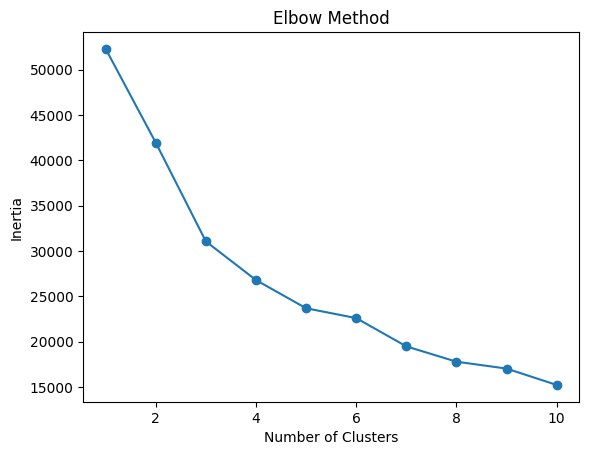

In [414]:
plt.plot(range(1, 11), inertia, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [418]:
print(f"Rows in merged_df: {merged_df.shape[0]}")
print(f"Rows in scaled_data: {scaled_data.shape[0]}")

Rows in merged_df: 9955
Rows in scaled_data: 8380


In [420]:
merged_df = merged_df.iloc[:scaled_data.shape[0]]

In [422]:
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['clusters'] = kmeans.fit_predict(scaled_data)

In [424]:
sil_score = silhouette_score(scaled_data, merged_df['clusters'])
print(f'Silhouette Score: {sil_score:.2f}')

Silhouette Score: 0.38


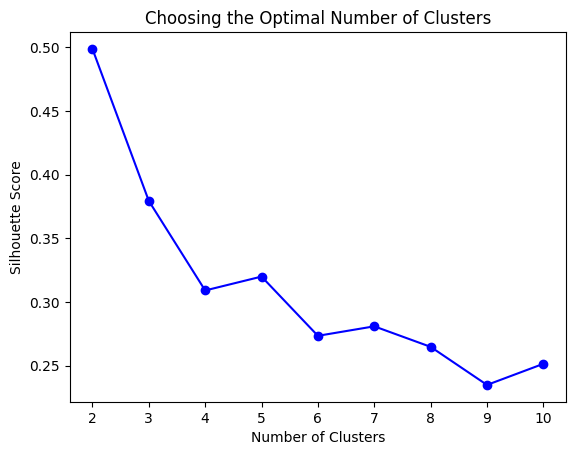

Best number of clusters: 2, Silhouette Score: 0.50


In [426]:
scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, cluster_labels)
    scores.append(score)

# Plot the scores
plt.plot(range(2, 11), scores, marker='o', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Choosing the Optimal Number of Clusters')
plt.show()

# Finding the best k
best_k = range(2, 11)[scores.index(max(scores))]
print(f'Best number of clusters: {best_k}, Silhouette Score: {max(scores):.2f}')

In [428]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_data)

In [430]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
merged_df['clusters_label'] = kmeans.fit_predict(reduced_features)

In [432]:
new_score = silhouette_score(reduced_features, merged_df['clusters_label'])
print(f'New Silhouette Score after PCA: {new_score:.2f}')

New Silhouette Score after PCA: 0.49


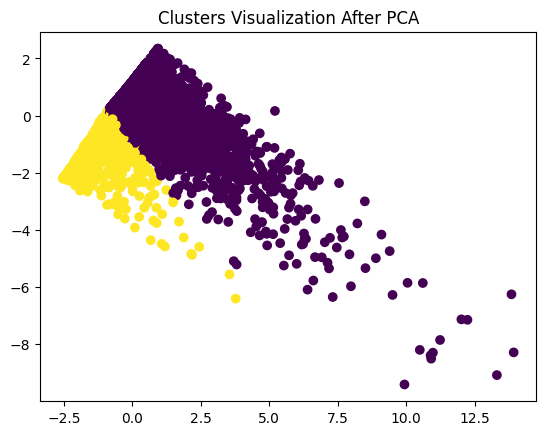

In [434]:
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=merged_df['clusters_label'], cmap='viridis')
plt.title('Clusters Visualization After PCA')
plt.show()

In [436]:
merged_df

,Restaurant,Reviewer,Review,Rating,Reviews,Followers,Time,Pictures,Year,Word List,Cleaned Text,Sentiment_Score,Sentiment_Label,Links,Cost,Collections,Cuisines,Timings,clusters,clusters_label
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,1,2.0,2019-05-25 15:54:00,0,2019,"[the, ambience, was, good, food, was, quite, g...",the ambience was good food was quite good had ...,0.9664,Positive,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",2,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,3,2.0,2019-05-25 14:20:00,0,2019,"[ambience, is, too, good, for, a, pleasant, ev...",ambience is too good for a pleasant evening se...,0.9360,Positive,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",2,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,2,3.0,2019-05-24 22:54:00,0,2019,"[a, must, try, great, food, great, ambience, t...",a must try great food great ambience thnx for ...,0.9186,Positive,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",2,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,1,1.0,2019-05-24 22:11:00,0,2019,"[soumen, das, and, arun, was, a, great, guy, o...",soumen das and arun was a great guy only becau...,0.8591,Positive,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",2,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,3,2.0,2019-05-24 21:37:00,0,2019,"[food, is, good, we, ordered, kodi, drumsticks...",food is good we ordered kodi drumsticks and ba...,0.9432,Positive,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)",2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8375,GD's,Yogyatha Veluru,10 mins before the ETA. super like,5.0,0,NaN,2018-07-25 23:15:00,0,2018,"[10, mins, before, the, eta, super, like]",10 mins before the eta super like,0.7506,Positive,https://www.zomato.com/hyderabad/gds-gachibowli,500,Unknown,"Burger, American",11:30 AM to 5 AM,2,0
8376,GD's,Prabhjit Thind,Delivery boy hasn't reached yet. Told me to co...,1.0,2,105.0,2018-07-23 00:48:00,0,2018,"[delivery, boy, hasnt, reached, yet, told, me,...",delivery boy hasnt reached yet told me to come...,-0.7000,Negative,https://www.zomato.com/hyderabad/gds-gachibowli,500,Unknown,"Burger, American",11:30 AM to 5 AM,2,0
8377,GD's,Pavan Srinivas,Charging 110 for a sandwich and yet no brown b...,3.0,6,3.0,2018-07-22 22:28:00,0,2018,"[charging, 110, for, a, sandwich, and, yet, no...",charging 110 for a sandwich and yet no brown b...,-0.2960,Negative,https://www.zomato.com/hyderabad/gds-gachibowli,500,Unknown,"Burger, American",11:30 AM to 5 AM,2,0
8378,GD's,Rahul Poojari,Best burger,5.0,1,1.0,2018-07-22 21:43:00,0,2018,"[best, burger]",best burger,0.6369,Positive,https://www.zomato.com/hyderabad/gds-gachibowli,500,Unknown,"Burger, American",11:30 AM to 5 AM,2,0


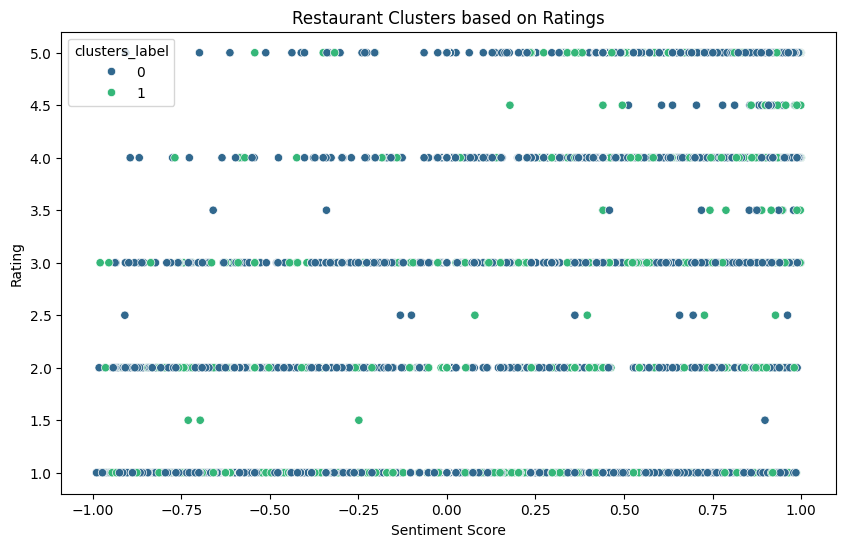

In [438]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = merged_df, x = 'Sentiment_Score', y = 'Rating', hue = 'clusters_label', palette = 'viridis')
plt.xlabel('Sentiment Score')
plt.ylabel('Rating')
plt.title('Restaurant Clusters based on Ratings')
plt.show()

- Cluster 0 (purple) shows a wide spread of sentiment scores, but ratings are mostly concentrated between 3 and 4. This suggests that these restaurants receive mixed feedback, leaning slightly positive, but rarely achieving outstanding ratings.
- Cluster 1 (blue) covers the entire sentiment score range, from highly negative to highly positive, with a strong presence around ratings of 3 to 4.5. This indicates a balanced perception — restaurants in this cluster are generally "good enough" but don't consistently impress.
- Cluster 2 (green) is heavily skewed toward higher ratings (4 to 5) and positive sentiment scores, indicating that restaurants in this cluster are seen very favorably, likely due to consistently good food or service.
- Cluster 3 (yellow), despite being smaller, shows a notable concentration at the high end of ratings (4.5 to 5) and sentiment scores, representing top-performing restaurants that receive overwhelmingly positive feedback.

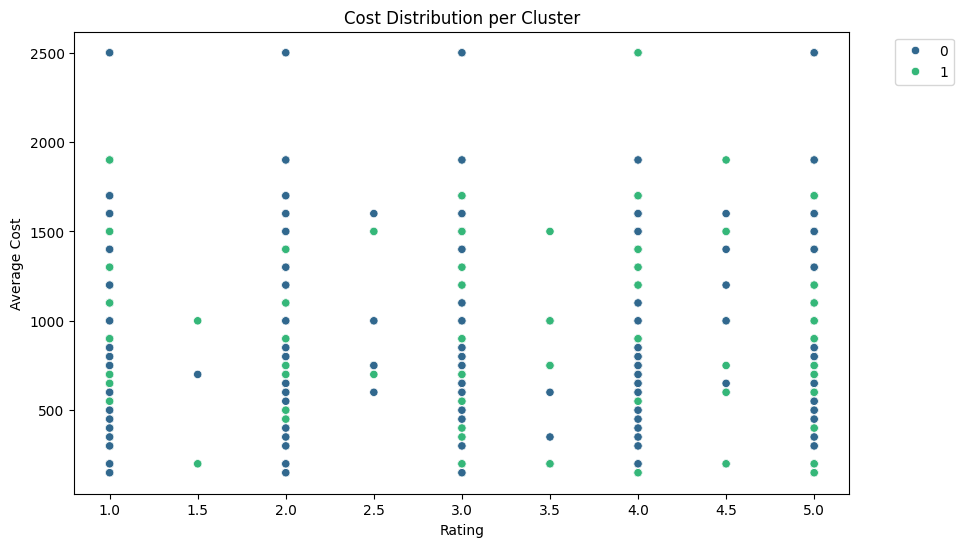

In [440]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Rating', y='Cost', hue = 'clusters_label', palette='viridis')
plt.title('Cost Distribution per Cluster')
plt.ylabel('Average Cost')
plt.xlabel('Rating')
plt.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1))
plt.show()

- Cluster 0 (purple) shows a wide cost range, but restaurants tend to have moderate ratings (3 to 4) despite varying costs. This suggests that cost doesn’t strongly correlate with higher ratings in this group.
- Cluster 1 (blue) dominates the lower cost range and spans all ratings. These restaurants are budget-friendly but receive mixed reviews, implying that low-cost doesn’t guarantee a high rating.
- Cluster 2 (green) represents restaurants with both mid-range and high costs, leaning towards higher ratings (4 to 5). These could be more premium spots that deliver quality, earning customer satisfaction.
- Cluster 3 (yellow), although smaller, stands out with higher costs and generally higher ratings, indicating an elite set of restaurants with strong positive reception despite the price.

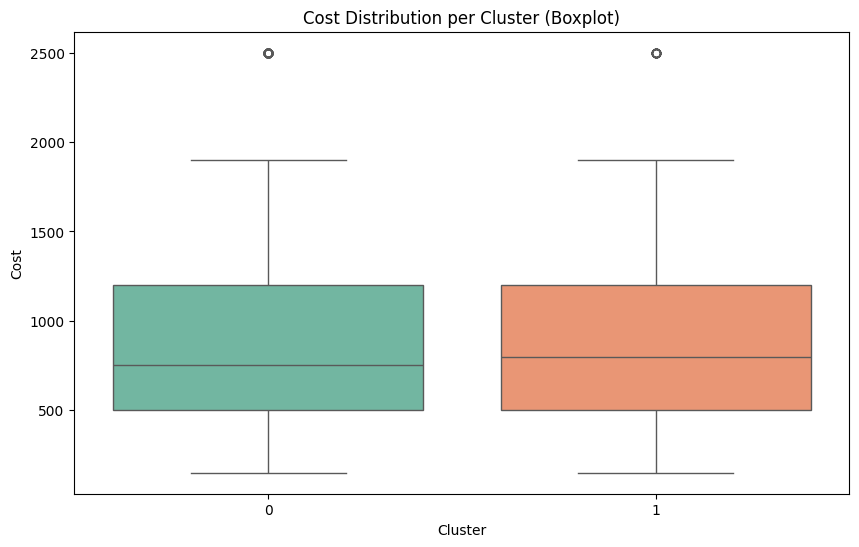

In [442]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='clusters_label', y='Cost', palette= 'Set2')
plt.title('Cost Distribution per Cluster (Boxplot)')
plt.xlabel('Cluster')
plt.ylabel('Cost')
plt.show()

- Cluster 0 has a moderate cost range, with a median around 800, and a few higher-cost outliers, indicating a balanced mix of affordable and pricier spots.
- Cluster 1 has the lowest median cost, suggesting it contains budget-friendly restaurants, though it has multiple cost outliers that stretch toward higher ranges.
- Cluster 2 displays a higher median cost than Clusters 0 and 1, with a wide spread, indicating diverse pricing — from budget to premium options.
- Cluster 3 has the highest median and overall cost range, implying it's dominated by more expensive, possibly upscale restaurants.

# Conclusion:

- Cluster 0: Diverse, with mixed ratings and costs — likely casual or inconsistent experiences.
- Cluster 1: Budget-friendly, well-rated spots — ideal for affordable, reliable dining.
- Cluster 2: Balanced, moderately priced, and high-rated — a sweet spot for quality and cost.
- Cluster 3: High-end, premium restaurants with positive sentiment — suited for upscale dining.

- Sentiment analysis — it revealed that ratings alone aren’t enough. Emotional perception (sentiment) plays a huge role in restaurant success. Restaurants should monitor sentiment trends and react quickly to negative shifts.

This clustering effectively segments restaurants into meaningful groups, aiding targeted recommendations — whether someone seeks budget eats, balanced value, or premium experiences.